# Fraud Detection Model Development and Evaluation with Computer Vision Techniques

***import necessay packages and libraries***

In [26]:
import pandas as pd
import os
import cv2  # OpenCV library for image processing
import matplotlib.pyplot as plt

In [43]:
# Dataset Extraction from local directory
df=pd.read_csv('train/train.csv')
df.head()

,image_id,filename,label
0,1,1.jpg,0
1,2,2.jpg,0
2,3,3.jpg,0
3,4,4.jpg,0
4,5,5.jpg,0


In [37]:
df['label'].value_counts()

label
0    7614
1     465
Name: count, dtype: int64

***Class Distribution***

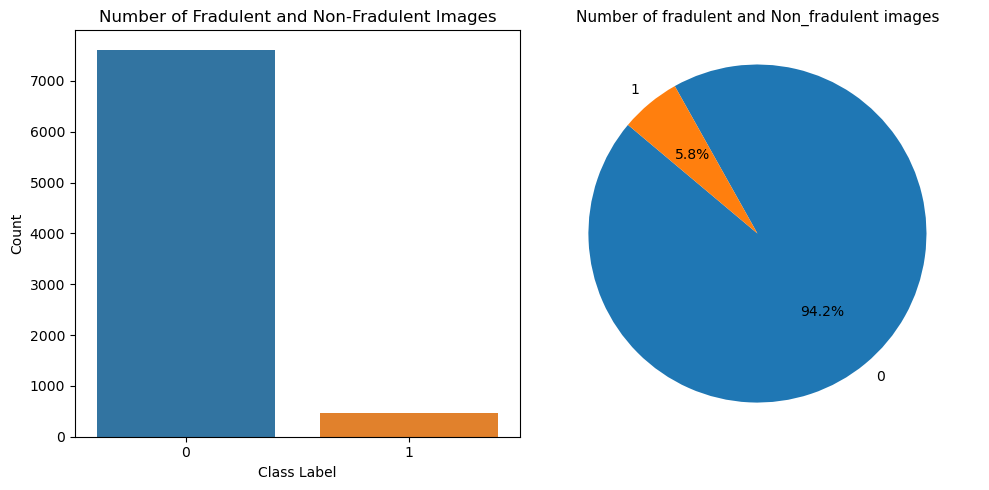

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate counts of each class
class_counts = df['label'].value_counts()

# Plot using seaborn
plt.figure(figsize=(10, 5))

# Bar plot
plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Fradulent and Non-Fradulent Images")
plt.xlabel("Class Label")
plt.ylabel("Count")

# Pie plot
plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Number of fradulent and Non_fradulent images", fontsize=11)
plt.axis('equal')

plt.tight_layout()
plt.show()


In [1]:
# path which all images are store in our directory
directory_path = 'train/images'

# Function to load images from directory
def load_images_from_directory(df, directory_path):
    images = []
    labels = []
    for index, df in df.iterrows():
        filename = df['filename']
        label = df['label']
        image_path = os.path.join(directory_path, filename)
        image = cv2.imread(image_path)
        #resize all images into the same size
        image= cv2.resize(image,(128,128))
        images.append(image)
        labels.append(label)
    return images, labels

# Load images and labels from directory
images, labels = load_images_from_directory(df, directory_path)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [9]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

oversampler = RandomOverSampler(random_state=42)
images_resampled, labels_resampled = oversampler.fit_resample(images.reshape(-1, images.shape[1]*images.shape[2]*images.shape[3]), labels)

# Reshape images back to original shape
images_resampled = images_resampled.reshape(-1, images.shape[1], images.shape[2], images.shape[3])

# Split data into training and testing sets - 80% data training and 20% data testing
X_train, X_test, y_train, y_test = train_test_split(images_resampled, labels_resampled, test_size=0.2, random_state=42)


In [10]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

In [12]:
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

1    6116
0    6066
dtype: int64

In [13]:
# Define input shape
input_shape = X_train[0].shape

In [14]:
input_shape

(128, 128, 3)

In [15]:
# Define the CNN model architecture
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))   # Droput for avoiding model overfitting
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dropout (Dropout)           (None, 57600)            

In [16]:
# Compile the model with Adam optimizer and loss function as binary cross entropy(binary class)
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [17]:
# Train the model using training data with 10 epochs and certain batch size
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


305/305 [==============================] - 133s 430ms/step - loss: 7.4525 - accuracy: 0.6803 - val_loss: 0.4937 - val_accuracy: 0.8190
Epoch 2/10
305/305 [==============================] - 131s 430ms/step - loss: 0.3485 - accuracy: 0.8564 - val_loss: 0.2016 - val_accuracy: 0.9274
Epoch 3/10
305/305 [==============================] - 130s 428ms/step - loss: 0.2190 - accuracy: 0.9140 - val_loss: 0.1688 - val_accuracy: 0.9491
Epoch 4/10
305/305 [==============================] - 136s 445ms/step - loss: 0.1855 - accuracy: 0.9297 - val_loss: 0.1120 - val_accuracy: 0.9713
Epoch 5/10
305/305 [==============================] - 134s 438ms/step - loss: 0.1226 - accuracy: 0.9564 - val_loss: 0.0670 - val_accuracy: 0.9811
Epoch 6/10
305/305 [==============================] - 131s 430ms/step - loss: 0.1178 - accuracy: 0.9595 - val_loss: 0.0835 - val_accuracy: 0.9774
Epoch 7/10
305/305 [==============================] - 130s 427ms/step - loss: 0.0773 - accuracy: 0.9735 - val_loss: 0.0624

In [19]:
# save the model in our directory
model.save('model.keras')

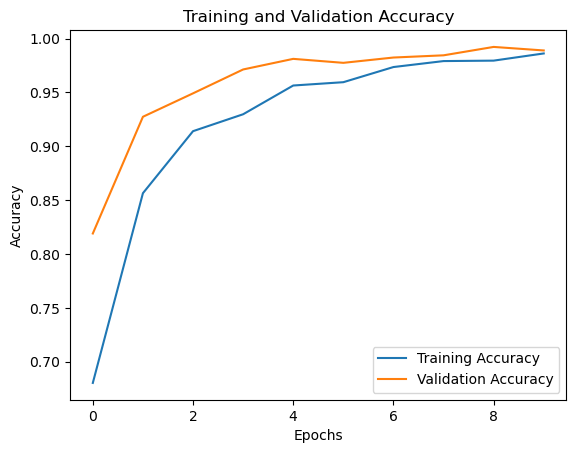

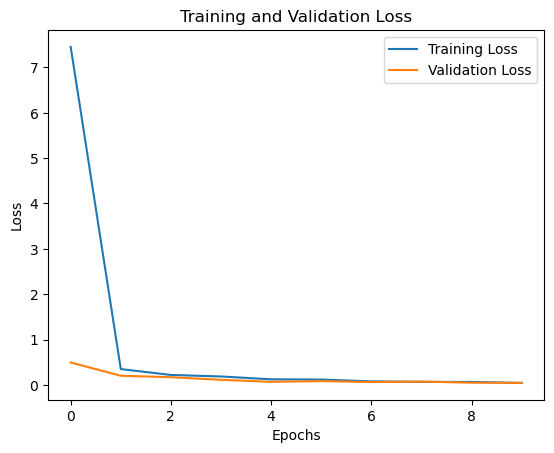

In [20]:
# Plot training and validation accuracy values over the number of epoochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss values over the number of epoochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

96/96 [==============================] - 9s 91ms/step - loss: 0.0249 - accuracy: 0.9934
Test Loss: 0.02491174079477787
Test Accuracy: 0.9934340119361877


In [24]:
# Predict labels for testing data
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report,f1_score
predicted_labels = model.predict(X_test)
predicted_labels = (predicted_labels > 0.5).astype(int)

96/96 [==============================] - 9s 91ms/step


***Performance Metrics of the Model***

In [25]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report,f1_score
print('Classification Report')
print(classification_report(y_test,predicted_labels))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1548
           1       0.99      1.00      0.99      1498

    accuracy                           0.99      3046
   macro avg       0.99      0.99      0.99      3046
weighted avg       0.99      0.99      0.99      3046



confusion matrix:


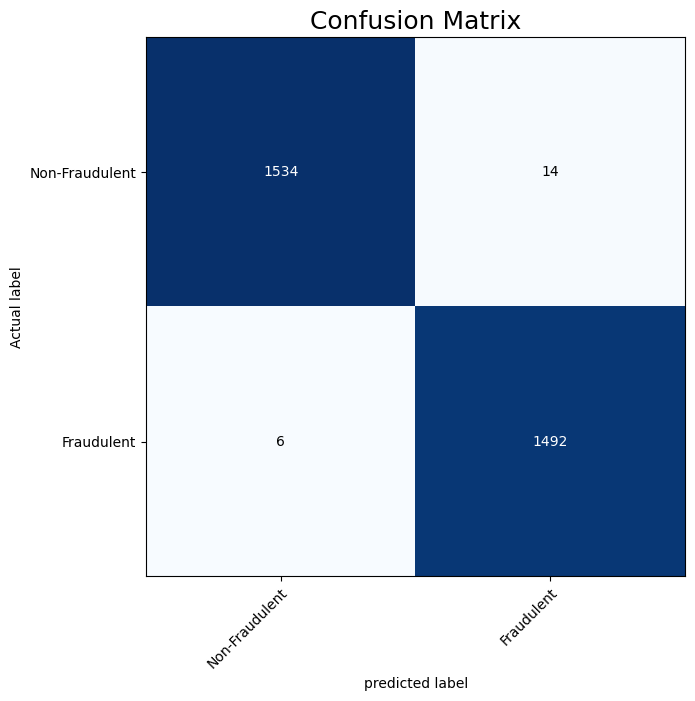

In [28]:
print("confusion matrix:")
from sklearn import metrics
import numpy as np
import seaborn as sns
conf_matrix = confusion_matrix(y_test,predicted_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(7, 7), cmap=plt.cm.Blues,class_names=['Non-Fraudulent','Fraudulent'])
plt.ylabel('Actual label', fontsize=10)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
# Compute performance metrics on test set
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9934340118187788
Precision: 0.9907038512616202
Recall: 0.9959946595460614
F1-score: 0.9933422103861518


***Model Prediction***

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model=load_model('model.h5')
def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128,128))   #Resize the original image into (128,128) shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape expected by the model

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"  # Here we did binary classification with a threshold of 0.5

    return predicted_class


image_path = "train/images/2.jpg"  # Provide the path to our input image
prediction = predict_image(image_path, model)
print("Prediction:", prediction)


1/1 [==============================] - 0s 103ms/step
Prediction: non-fraudulent


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model=load_model('model.h5')
def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128,128,3))  # Provide your target size here
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape expected by the model
    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"  #binary classification with a threshold of 0.5

    return predicted_class

# Example usage:
image_path = "train/images/7501.jpg"  # Provide the path to your image
prediction = predict_image(image_path, model)
print("Prediction:", prediction)


1/1 [==============================] - 0s 104ms/step
Prediction: fraudulent


***Create webframework using Gradio***

In [24]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model = load_model('model.h5')

# Define function to predict image class
def predict_image(image_file):
    # Load and preprocess the image
    img = image.array_to_img(image_file, scale=False)
    img = img.resize((128, 128)) 
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"
    print(f"The model predicted that this image belongs to a {predicted_class} class.")
    return predicted_class

# Create a Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs="image",  # Here we give input as image
    outputs="text",  # We will return the predicted class as output
    title="Fraud Detection Model",  # Interface title
    description="Upload an image to process.",
)

# Launch the interface
interface.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 129ms/step
The model predicted that this image belongs to a non-fraudulent class.
